# 1. Import Dependencies

In [3]:
from collections import defaultdict # Allow access to keys do not access
import matplotlib.pyplot as plt
from matplotlib.patches import Patch # draw shaped
import numpy as np
import seaborn as sns

from tqdm import tqdm

import gymnasium as gym
%matplotlib inline


from __future__ import annotations

# Observing the Environment

First of all, we call ``env.reset()`` to start an episode. This function
resets the environment to a starting position and returns an initial
``observation``. We usually also set ``done = False``. This variable
will be useful later to check if a game is terminated (i.e., the player wins or loses).




In [4]:
environment_name = 'Blackjack-v1'
env = gym.make(environment_name, sab=True, render_mode="rgb_array")

In [5]:
environment_name 

'Blackjack-v1'

In [6]:
# Reset the environment to get the first observation

done = False
observation, info = env.reset()

# observation = (16, 9, False)


#### Note that our observation is a tuple consisting of 3 values:
1. The player's current sum
2. Values of the dealers face-up card
3. Boolean whether the player holds a usable ace (it is usale if it counts as 11 without busting)

## Executing an action in the environment

After receiving our first observation, we are only going to use the
``env.step(action)`` function to interact with the environment. This
function takes an action as input and executes it in the environment.
Because that action changes the state of the environment, it returns
four useful variables to us. These are:

-  ``next_state``: This is the observation that the agent will receive
   after taking the action.
-  ``reward``: This is the reward that the agent will receive after
   taking the action.
-  ``terminated``: This is a boolean variable that indicates whether or
   not the environment has terminated.
-  ``truncated``: This is a boolean variable that also indicates whether
   the episode ended by early truncation, i.e., a time limit is reached.
-  ``info``: This is a dictionary that might contain additional
   information about the environment.

The ``next_state``, ``reward``,  ``terminated`` and ``truncated`` variables are
self-explanatory, but the ``info`` variable requires some additional
explanation. This variable contains a dictionary that might have some
extra information about the environment, but in the Blackjack-v1
environment you can ignore it. For example in Atari environments the
info dictionary has a ``ale.lives`` key that tells us how many lives the
agent has left. If the agent has 0 lives, then the episode is over.

Note that it is not a good idea to call ``env.render()`` in your training
loop because rendering slows down training by a lot. Rather try to build
an extra loop to evaluate and showcase the agent after training.

In [7]:
action = env.action_space.sample()
# action = 1

# execute the action in our environment and receive info after taking the step0
observation, reward, terminated, truncated, info = env.step(action)

#observation = (24, 10, False)
#reward = -1.0
#terminated = True
#truncated = False
#info = {}

In [8]:
observation, reward, terminated, truncated, info

((23, 8, 0), -1.0, True, False, {})

If terminated=True, we should stop the current episode and begin a new one using env.reset()

### Understand and Implement Epsion-greedy strategy to solve Blackjack

1. In this strategy, the agent takes an action that is either the best action based on the current policy (with a probability of 1-epsilon) or a random action (with a probability of epsilon). This approach balances the exploitation of the current best policy with exploration of new policies, which can lead to better rewards in the long run.

2. In the context of Blackjack, the epsilon-greedy strategy can be applied to determine whether the player should hit or stand. At each step of the game, the agent(i.e., the player) can choose to take the action that is either recommended by the current policy or a random action. the policy is learned over time by updating the action-value estimates of each state-action pair based on the rewards received during the game.

3. As the game is played repeatedly, the agen learns the optimal policy that maximizes the expected reward. Initially, the agent may explore by taking random actions to discover new strategies. However, as the game progresses, the agent will start to exploit the best-known policy, which should maximize the expected reward over time.

In [9]:
# Agent
class BlackjackAgent:
    def __init__(
        self, 
        learning_rate:float, 
        initial_epsilon:float,
        epsilon_decay:float,
        final_epsilon:float,
        discount_factor:float=0.95
    ):
        """
        Initialize a RL agent with empty dictionary of state-action value (q_value), a learning rate, and an epsilon
        
        Args:
            learning_rate: The learning rate
            initial_epsilon: The initial epsilon value
            epsilon_decay: The decay for epsilon
            final_epsilon: The final epsilon value
            discount_factor: The discount factor for computing the Q-value
        """
        self.q_values=defaultdict(lambda:np.zeros(env.action_space.n))
        self.lr = learning_rate
        self.discount_factor = discount_factor
        
        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon
        
        self.training_error = []
        
    def get_action(self, obs:tuple[int, int, bool]) -> int:
        """
        Return the best action with probability (1 - epsilon) 
        otherwise a random action with probability epsilon to ensure exploration.
        """
        if np.random.random() < self.epsilon:
            return env.action_space.sample()
        else:
            return int(np.argmax(self.q_values[obs]))
        
    def update(self, obs:tuple[int, int, bool], action:int, reward:float, terminated:bool, next_obs:tuple[int, int, bool]):
        """
        Updates the Q-value of an actions
        """
        future_q_value = (not terminated) * np.max(self.q_values[next_obs])
        temporal_difference = (reward + self.discount_factor * future_q_value - self.q_values[obs][action])
        
        self.q_values[obs][action] = self.q_values[obs][action] + self.lr * temporal_difference
        
        self.training_error.append(temporal_difference)
    
    
    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - epsilon_decay)  
        

Q-value function is used to estimate the optimal action to take in each state. It is the one that maximized the long-term reward and is given by.

To train the agent, we will let the agent play one episode (one complete game is called an episode) at a time and the update it's Q-values after each episode. The agent will have to explerience a lot of episodes to explore the environment sufficiently.

Now we should be ready to build the training loop.

In [10]:
# Hyperparameters

learning_rate=0.01
n_episodes=100_000
start_epsilon=1.0
epsilon_decay=start_epsilon / (n_episodes / 2) # reduce the exploration over time
final_epsilon=0.1

agent = BlackjackAgent(
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon
)

# Training with the Visual

In [ ]:
# # from IPython.display import clear_output

# env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)
# for episode in tqdm(range(n_episodes)):
#     obs, info = env.reset()
#     done = False
# #     clear_output()
    
#     # play one episode:
#     while not done:
#         action = agent.get_action(obs)
#         next_obs, reward, terminated, truncated, info = env.step(action)
        
#         agent.update(obs, action, reward, terminated, next_obs)
#         frame = env.render()
#         plt.imshow(frame)
#         plt.show()
        
#         done = terminated or truncated
#         obs = next_obs
        
#     agent.decay_epsilon()

### Training without visual

In [11]:
env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)
for episode in tqdm(range(n_episodes)):
    obs, info = env.reset()
    done = False
#     clear_output()
    
    # play one episode:
    while not done:
        action = agent.get_action(obs)
        next_obs, reward, terminated, truncated, info = env.step(action)
        
        agent.update(obs, action, reward, terminated, next_obs)
        
        done = terminated or truncated
        obs = next_obs
        
    agent.decay_epsilon()

100%|████████████████████████████████████████████████████████████████████████| 100000/100000 [00:39<00:00, 2548.23it/s]


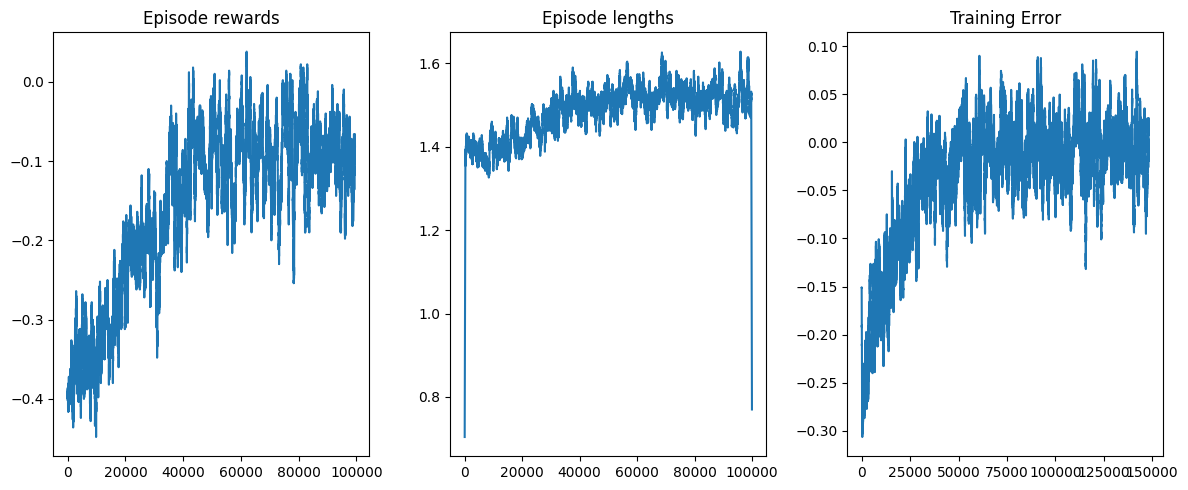

In [12]:
rolling_length = 500
fig, ax = plt.subplots(ncols=3, figsize=(12, 5))

ax[0].set_title("Episode rewards")
reward_moving_average = (
    np.convolve(
        np.array(env.return_queue).flatten(),
        np.ones(rolling_length),
        mode='valid'
    ) / rolling_length
)
ax[0].plot(range(len(reward_moving_average)), reward_moving_average)

ax[1].set_title('Episode lengths')
length_moving_average = (
    np.convolve(
        np.array(env.length_queue).flatten(),
        np.ones(rolling_length),
        mode='same'
    ) / rolling_length
)
ax[1].plot(range(len(length_moving_average)), length_moving_average)

ax[2].set_title('Training Error')
training_error_moving_average = (
    np.convolve(
        np.array(agent.training_error),
        np.ones(rolling_length),
        mode='same'
    ) / rolling_length
)
ax[2].plot(range(len(training_error_moving_average)), training_error_moving_average)

plt.tight_layout()
plt.show()

# Visualizing the policy

In [13]:
def create_grids(agent, usable_ace=False):
    """Create value and policy grid given an agent"""
    # Convert our state-action values to state values
    # and build a policy dictionary that maps observations to actions
    state_value = defaultdict(float)
    policy = defaultdict(int)
    
    for obs, action_values in agent.q_values.items():
        state_value[obs] = float(np.max(action_values))
        policy[obs] = int(np.argmax(action_values))
        
        
    player_count, dealer_count = np.meshgrid(
        # players count, dealers face-up card
        np.arange(12, 22),
        np.arange(1, 11)
    )
    
    # Create the value grid for plotting
    value = np.apply_along_axis(
        lambda obs: state_value[(obs[0], obs[1], usable_ace)], 
        axis=2,
        arr = np.dstack([player_count, dealer_count])
    )
    value_grid = player_count, dealer_count, value
    
    # Create the policy grid for plotting
    policy_grid = np.apply_along_axis(
        lambda obs: policy[(obs[0], obs[1], usable_ace)],
        axis = 2,
        arr = np.dstack([player_count, dealer_count])
    )
    
    return value_grid, policy_grid



In [14]:


def create_plots(value_grid, policy_grid, title: str):
    """Create a plot using a value and policy grid"""
    # Create a new figure with 2 subplots (left: state_values, right: policy)
    player_count, dealer_count, value = value_grid
    fig = plt.figure(figsize=plt.figaspect(0.4))
    fig.suptitle(title, fontsize=16)
    
    # Plot the state values
    ax1 = fig.add_subplot(1, 2, 1, projection="3d")
    ax1.plot_surface(
        player_count,
        dealer_count,
        value,
        rstride=1,
        cstride=1,
        cmap='viridis',
        edgecolor='none'
    )
    
    plt.xticks(range(12, 22), range(12, 22))
    plt.yticks(range(1, 11), ['A'] + list(range(2, 11)))
    ax1.set_title(f'State values: {title}')
    ax1.set_xlabel('Player sum')
    ax1.set_ylabel('Dealer showing')
    ax1.zaxis.set_rotate_label(False)
    ax1.set_zlabel('value', fontsize=14, rotation=90)
    ax1.view_init(20, 220)
    
    
    # Plot the policy
    fig.add_subplot(1, 2, 2)
    ax2 = sns.heatmap(policy_grid, linewidth=0, annot=True, cmap='Accent_r', cbar=False)
    ax2.set_title(f'Policy: {title}')
    ax2.set_xlabel('Player sum')
    ax2.set_ylabel('Dealer showing')
    ax2.set_xticklabels(range(12, 22))
    ax2.set_yticklabels(['A'] + list(range(2, 11)), fontsize=12)
    
    
    # Add a legent
    legend_elements = [
        Patch(facecolor='lightgreen', edgecolor='black', label='Hit'),
        Patch(facecolor='grey', edgecolor='black', label='Stick')
    ]
    ax2.legend(handles=legend_elements, bbox_to_anchor=(1.3, 1))
    return fig

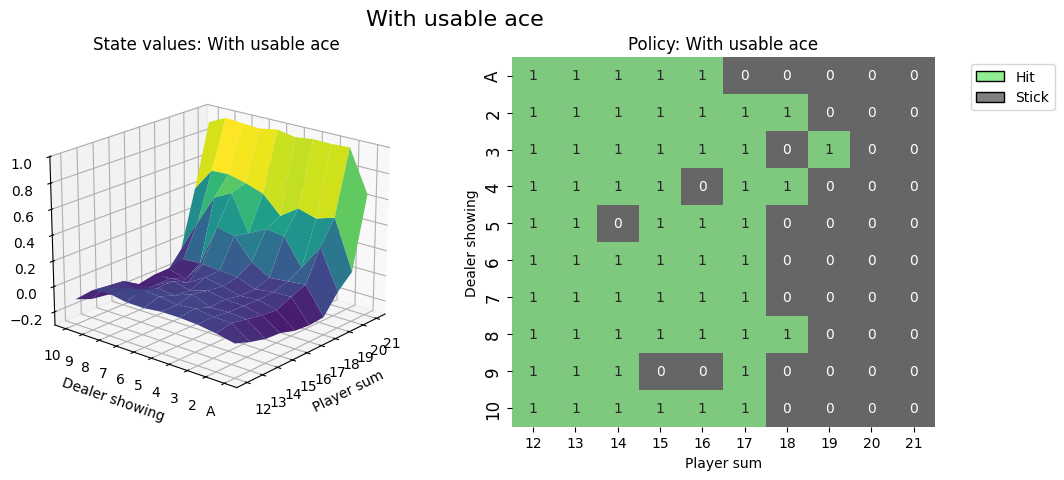

In [15]:
# State values & policy with usabel ace (ace counts as 11)
value_grid, policy_grid = create_grids(agent, usable_ace=True)
fig1 = create_plots(value_grid, policy_grid, title='With usable ace')
plt.show()

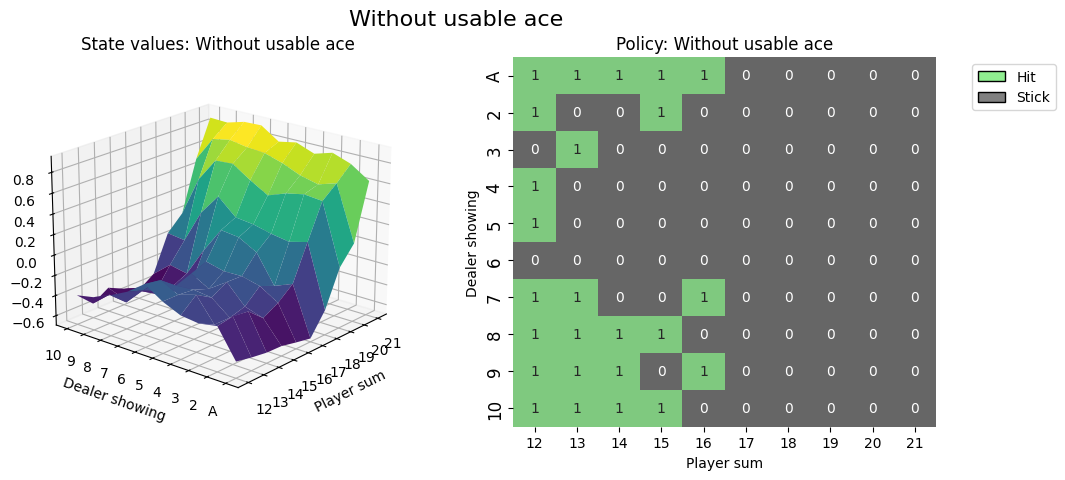

In [16]:
# State values & policy without usable ace (ace count as 1)
value_grid, policy_grid = create_grids(agent, usable_ace=False)
fig2 = create_plots(value_grid, policy_grid, title='Without usable ace')
plt.show()

# Other ways of solving BlackJack

1. Monte Carlo Method: Monte Carlo is a model-free method that learns from experience. In the context of BlackJact, Monte Carlo method involves playing the game several times and keeping track of the rewards obtained for each action. The agent then updates its value function based on the average of the rewards obtained for each state-action pair. Monte Carlo methods are suitable or problems with episodic tasks like BlackJack.

2. Temporal Difference Method: Temporal difference (TD) method is another model-free method that learns from experience. In TD learning, the agent updates its value function based on the differnece between the predicted and actual reward. TD methods are suitable for problems with continuous tasks like BlackJack.

3. Q-Learning: Q-learning is a model-free reinforcement learning algorithm that learn the optimal policy by updating the Q-values for each state-action pair. The agent selects the action with the highest Q-value for a given state. Q-learning is suitable for problems with finite states and actions like Blackjack.

4. Deep Q-Networks (DQNs): Deep Q-Networks (DQNs) combine reinforcement learning with deep neural networks. DQNs learn the optimal policy by approximating the Q-values using a deep neural network. DQNs are suitable for problems with high-dimensional state spaces like image-based games.

5. Actor-Critic: Actor-Critic is a model-based reinforcement learning algorithm that uses two networks - an actor and a critic. The actor network selects the actions, while the critic network evaluates the actions taken by the actor. Actor-Critic is suitable for problems with continous action spaces like Blackjack.